## This ipynb was created by Wei-Yu Chen to demonstrate the mainstream approaches of calculating value-at-risk and a framework for backtesting.
### All copyright reserved

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 15)
import sqlalchemy 
import tejapi
import numpy as np
from datetime import date,timedelta
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
import pandas_datareader.data as web
import datetime 
from arch import arch_model
import math

### 1. Create a pseudo portfolio with Yahoo assets price data

In [2]:
start = datetime .datetime(2005, 1, 1)
end = datetime .datetime(2022, 1, 1)
sp500 = web.DataReader('^GSPC', 'yahoo', start=start, end=end)
N225 = web.DataReader('^N225', 'yahoo', start=start, end=end)
gold = web.DataReader('GC=F', 'yahoo', start=start, end=end)
shanghai_index = web.DataReader('000001.SS', 'yahoo', start=start, end=end)
vanguardBond = web.DataReader('VBMFX', 'yahoo', start=start, end=end)
nasdaqIndex = web.DataReader('^IXIC', 'yahoo', start=start, end=end)

In [6]:
n225_pl = N225['Adj Close'].to_frame('Nikkei 225 Index').dropna()
gold_pl = gold['Adj Close'].to_frame('Gold').dropna()
shi_pl = shanghai_index['Adj Close'].to_frame('Shanghai Composite Index').dropna()
sp500_pl = sp500['Adj Close'].to_frame('S&P500 Index').dropna()
bond_pl = vanguardBond['Adj Close'].to_frame('Vanguard Bond Index Fund').dropna()
comm_pl = nasdaqIndex['Adj Close'].to_frame('Nasdaq Index').dropna()
portfolio_prices = sp500_pl.merge(n225_pl,right_index=True, left_index = True).merge(gold_pl,right_index=True, left_index = True).merge(shi_pl,right_index=True, left_index = True)
portfolio_prices = portfolio_prices.merge(bond_pl,right_index=True, left_index = True).merge(comm_pl,right_index=True, left_index = True)
summary_PnL = portfolio_prices.pct_change().dropna()
portfolio_prices.head(3).style.format('{:,.4f}')

,S&P500 Index,Nikkei 225 Index,Gold,Shanghai Composite Index,Vanguard Bond Index Fund,Nasdaq Index
Date,,,,,,
2005-01-04 00:00:00,"1,188.0500","11,517.7500",428.5000,"1,242.7740",6.0919,"2,107.8601"
2005-01-05 00:00:00,"1,183.7400","11,437.5195",426.6000,"1,251.9370",6.0919,"2,091.2400"
2005-01-06 00:00:00,"1,187.8900","11,492.2598",421.0000,"1,239.4301",6.0978,"2,090.0000"


In [7]:
summary_PnL = summary_PnL.reset_index().drop_duplicates(subset='Date', keep='last').set_index('Date').sort_index()
weights = np.array([.30,.30,.05,.10,.20,.05]) 

### 2. Create a value-at-risk class and define methods within.

In [19]:
class ValueAtRisk:
    
    '''
        1. The the first code block calculate basic peformance indicators of each asset in the portfolio.
            Please fill in a dataframe of assets daily PnL and the the following fuctions will calculate performance for the given sample perriod.
    '''
    
    def __init__(self, daily_return, weights):
        self.daily_return = daily_return
        self.weights = weights
        self.cov_matrix = daily_return.cov()
        self.overview = self.portfolio_overview(daily_return,weights)

    
    def portfolio_overview(self,df,weights,period=250):
        df = df[-period:]
        df['Total Portfolio'] = np.average(df, 1, weights)
        cols = df.columns 
        feature_idx = ['Number of observations:','Mean return (daily):','Standard deviation (daily):','Sharpe ratio (annualized):',
                     'Period return:','Geometric mean of 1+r:','Maximum drawdown:','Maximum drawdown duration:']
        perf_table = pd.DataFrame()
        perf_table['Asset/Performance'] = feature_idx
        for col in cols:
            perf = self.performance_analysis(df[col],col)
            perf_table = perf_table.merge(perf,on='Asset/Performance')
            perf_table = perf_table.set_index('Asset/Performance')
        return perf_table.T

        
        '''
        2. This code block includes functions that apply different approaches of calculating VaR.
            Please input a dataframe of assets daily PnL and the the following fuctions will calculate VaR for the given sample perriod.
        '''
        
    def parametric(self, daily_return, weights):
        cov_matrix = daily_return.cov()
        date = daily_return.index.max()
        z1 = norm.ppf(5/100)
        z2 = norm.ppf(1/100)
        z3 = norm.ppf(2.5/100)
        daily_mean = np.average(daily_return, 1, weights)
        port_mean =daily_mean.mean()
        port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
        var_95 = port_mean + z1 * port_stdev 
        var_99 = port_mean + z2 * port_stdev 
        var_975 = port_mean + z3 * port_stdev 
        cvar_975 = np.mean(daily_mean[daily_mean < var_975])
        var_dict = {'VaR(95%)':var_95,'VaR(99%)':var_99,'Expected Shortfall(97.5%)':cvar_975}
        df = pd.DataFrame(var_dict,index=[date])
        return df
    
    def historic(self,daily_return,weights):
        cov_matrix = daily_return.cov()
        date = daily_return.index.max()
        daily_return = np.average(daily_return, 1, weights)
        var_95 = np.percentile(daily_return,5)
        var_99 = np.percentile(daily_return,1)
        var_975 = np.percentile(daily_return,2.5)
        cvar_975 = np.mean(daily_return[daily_return < var_975])
        var_dict = {'VaR(95%)':var_95,'VaR(99%)':var_99,'Expected Shortfall(97.5%)':cvar_975}
        df = pd.DataFrame(var_dict,index=[date])
        return df
    
    def monte_carlo(self, daily_return,weights):
        date = daily_return.index.max()
        mu = np.mean(np.average(daily_return, 1, weights))
        vol = np.std(np.average(daily_return, 1, weights))
        T = 250
        simulated_PnL = []
        for i in range(T):
            rand_rets = np.random.normal(mu, vol, 1000)
            simulated_PnL.append(rand_rets)
        var_95 = np.percentile(simulated_PnL,5)
        var_975 = np.percentile(simulated_PnL,2.5)
        var_99 = np.percentile(simulated_PnL,1)

        PnL_frame = pd.DataFrame(simulated_PnL)
        extrem_loss = PnL_frame[PnL_frame < var_975]
        #print(np.nanmean(extrem_loss))
        cvar_975 = np.nanmean(extrem_loss)

        var_dict = {'VaR(95%)':var_95,'VaR(99%)':var_99,'Expected Shortfall(97.5%)':cvar_975}
        df = pd.DataFrame(var_dict,index=[date])
        return df
    
    def garch(self,daily_return,weights):
        date = daily_return.index.max()
        weighted_avg = pd.DataFrame()
        weighted_avg['weighted_avg'] = np.average(daily_return, 1, weights) * 100
        am = arch_model(weighted_avg, vol='Garch', p=1, o=0 ,q=1, dist='skewt')
        res = am.fit(disp='off')
        forecasts = res.forecast()
        cond_mean = forecasts.mean
        cond_var = forecasts.variance
        q = am.distribution.ppf([0.05, 0.01, 0.025], res.params[-2:])
        value_at_risk = cond_mean.values + np.sqrt(cond_var).values * q[None, :]
        var_95 = value_at_risk[[-1,]][0][0]
        var_99 = value_at_risk[[-1,]][0][1]
        var_975 = value_at_risk[[-1,]][0][2]
        cvar_975 = np.mean(weighted_avg[weighted_avg['weighted_avg'] < var_975])
        if math.isnan(cvar_975):
            cvar_975 = [var_99]
        var_dict = {'VaR(95%)':var_95,'VaR(99%)':var_99,'Expected Shortfall(97.5%)':cvar_975[0]}
        df = pd.DataFrame(var_dict,index=[date])
        df = df / 100
        return df[-1:]
    
    def VaR_summary(self, df, weights, amount):
        summary = pd.DataFrame()
        summary = summary.append(self.parametric(df, weights)).append(self.historic(df, weights)).append(self.monte_carlo(df, weights)).append(self.garch(df, weights))
        idx = ['Parametric','Historical','Monte Carlo','GARCH']
        summary.index = idx
        summary.index.name = time.strftime("%Y-%m-%d")
        return summary * amount

        '''
        3. This code block defines function to generate data for backtest.
        '''
        
    def backtest_data(self, daily_return, weights, method, window_days=250):
        start_time = time.time()
        method_map = {'Parametric':self.parametric,'Historical':self.historic,'MonteCarlo':self.monte_carlo,'GARCH':self.garch}
        method_applied = method_map[method]        
        weighted_daily_PnL = pd.DataFrame(np.average(daily_return, 1, weights),index = daily_return.index, columns = ['Daily PnL'])
        daily_VaR_table = pd.DataFrame()
        for i in range(len(daily_return)-window_days):
            daily_PL = daily_return[i:i+window_days]
            date = daily_PL.index.max()
            daily_VaR = method_applied(daily_PL,weights)
            daily_VaR_table = daily_VaR_table.append(daily_VaR)

        daily_VaR_table.index = daily_VaR_table.index + pd.DateOffset(1)
        df = pd.merge_asof(weighted_daily_PnL,daily_VaR_table, right_index = True, left_index = True)
        df['VaR(95%) exception'] = np.where((df['VaR(99%)'] < df['Daily PnL']) & (df['Daily PnL'] < df['VaR(95%)']),'True','False')
        df['VaR(99%) exception'] = np.where(df['Daily PnL'] < df['VaR(99%)'],'True','False')  
        df = df.dropna()
        print(method+':',"--- %s seconds ---" % (time.time() - start_time))
        return df           
    
    def backtest_plot(self, VaR_table, model_name, begin_date='2007-01-01', end_date='2021-06-01'):
        VaR_table = VaR_table[begin_date:end_date]
        #Check dates where there is a VaR exception
        VaR_table['VaR(95%) exception'] = np.where((VaR_table['VaR(99%)'] < VaR_table['Daily PnL']) & (VaR_table['Daily PnL'] < VaR_table['VaR(95%)']),'True','False')
        VaR_table['VaR(99%) exception'] = np.where(VaR_table['Daily PnL'] < VaR_table['VaR(99%)'],'True','False')  
        
        obs = len(VaR_table)
        fig,ax = plt.subplots(1,1,figsize=(16,10))
        normal_PnL = VaR_table[(VaR_table['VaR(95%) exception']=='False') & (VaR_table['VaR(99%) exception']=='False')]['Daily PnL']
        #ax.scatter(normal_PnL.index,normal_PnL,color = '#1ba1e2',alpha=0.5)
        ax.plot(VaR_table['Daily PnL'], color = '#1ba1e2')
        ax.plot(VaR_table['VaR(95%)'], color = '#fa6800', alpha = 0.7)
        ax.plot(VaR_table['VaR(99%)'], color = '#e51400', alpha = 0.7)
        #ax.plot(VaR_table[['CVaR(95%)']])
        exceed_95 = VaR_table[VaR_table['VaR(95%) exception']=='True']['Daily PnL']
        exceed_99 = VaR_table[VaR_table['VaR(99%) exception']=='True']['Daily PnL']
        count_95 = (exceed_95.count() + exceed_99.count()) / obs
        count_99 = exceed_99.count() / obs

        r = VaR_table.index

        text_to_show ='Number of observations: ' + str(obs) + '\nVaR(95%) exceptions: ' + str(exceed_95.count() + exceed_99.count()) + '\nVaR(99%) exceptions: ' + str(exceed_99.count())
        ax.text(r[-(round(obs/4))], VaR_table['Daily PnL'].max()*.9, text_to_show,size=12)

        ax.scatter(exceed_95.index,exceed_95,marker='s',  facecolors='none', edgecolors='#BB00BB', s = 120) #'#BB00BB'
        ax.scatter(exceed_99.index,exceed_99,marker='x',  facecolors='#a20025', s = 120) ##a20025
        ax.spines['bottom'].set_color('#b0abab')
        ax.spines['top'].set_color('#b0abab')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(linestyle='--', alpha=0.5)
        ax.legend(['Daily PnL','VaR(95%)','VaR(99%)','VaR(95%), exception rates: ' + str(round(count_95*100,2))+'%',
                    'VaR(99%), exception rates: ' + str(round(count_99*100,2))+'%'],loc='upper left',prop={'size': 12})
        ax.set_title(model_name + ' VaR Backtest', fontsize=16, fontweight=1)
        plt.show()

### 3. Initiate a VaR object with an assets PnL table and portfolio weights.

In [9]:
VaR = ValueAtRisk(summary_PnL,weights)

####    a. The overview attribute is used to demontrate the assets performance within a given period. (The preset is 250 days)

In [10]:
VaR.overview

Asset/Performance,Number of observations:,Mean return (daily):,Standard deviation (daily):,Sharpe ratio (annualized):,Period return:,Geometric mean of 1+r:,Maximum drawdown:,Maximum drawdown duration:
S&P500 Index,250,0.001057,0.0224,0.6605,22.24%,1.000803,28.52%,57 days
Nikkei 225 Index,250,0.001104,0.0170,0.9144,27.13%,1.000961,26.77%,61 days
Gold,250,0.000335,0.0148,0.2298,5.81%,1.000226,18.22%,146 days
Shanghai Composite Index,250,0.000622,0.0128,0.6201,14.47%,1.000541,13.40%,73 days
Vanguard Bond Index Fund,250,0.000051,0.0034,-0.3216,1.13%,1.000045,6.53%,146 days
Nasdaq Index,250,0.001704,0.0233,1.0730,42.94%,1.001430,23.92%,48 days
Total Portfolio,250,0.000823,0.0114,0.9740,20.84%,1.000758,19.14%,58 days


####    b. The VaR summary table demonstrates VaR under different methods and confidence interval.

In [11]:
VaR.VaR_summary(summary_PnL,weights, 1000000).style.format('{:,.0f}')

,VaR(95%),VaR(99%),Expected Shortfall(97.5%)
2021-04-08,,,
Parametric,"-12,564","-17,925","-25,091"
Historical,"-10,974","-23,244","-24,978"
Monte Carlo,"-12,538","-17,989","-18,023"
GARCH,"-9,802","-16,724","-21,625"


####    c. The backtest_data function generate backtested VaR on a rolling basis. (The preset is 250 days)

In [12]:
#Backtest of 12 years data
para_var = VaR.backtest_data(summary_PnL, weights, 'Parametric')
hist_var = VaR.backtest_data(summary_PnL, weights, 'Historical')
mcvar = VaR.backtest_data(summary_PnL, weights, 'MonteCarlo')
garch_var = VaR.backtest_data(summary_PnL, weights, 'GARCH')

Parametric: --- 10.24504828453064 seconds ---
Historical: --- 8.65751838684082 seconds ---
MonteCarlo: --- 546.3645412921906 seconds ---
GARCH: --- 226.7594554424286 seconds ---


####    d. The backtest_plot function visualizes the backtested VaRs with identification of exceptions.

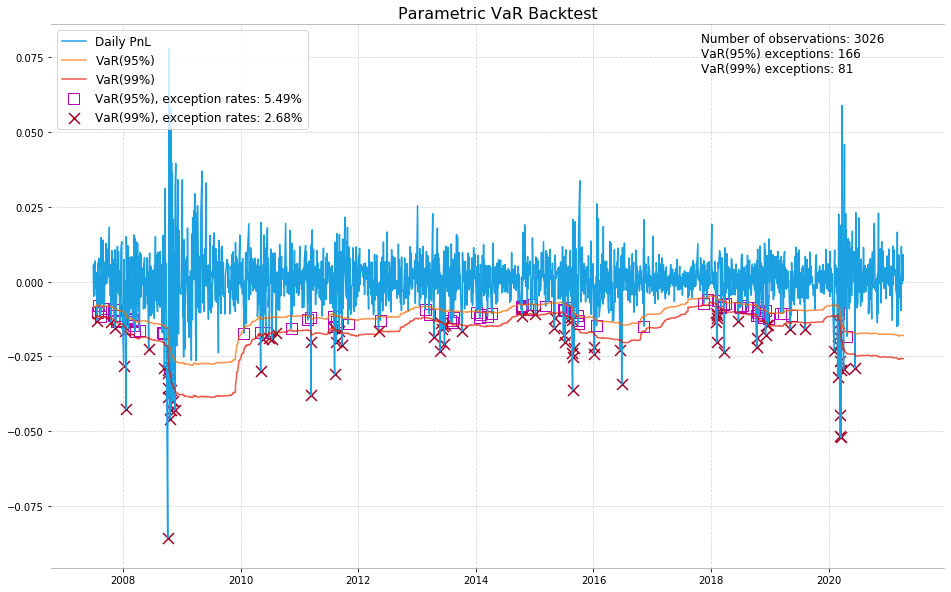

In [13]:
VaR.backtest_plot(para_var, 'Parametric', begin_date='2007-07-01', end_date='2021-06-01')

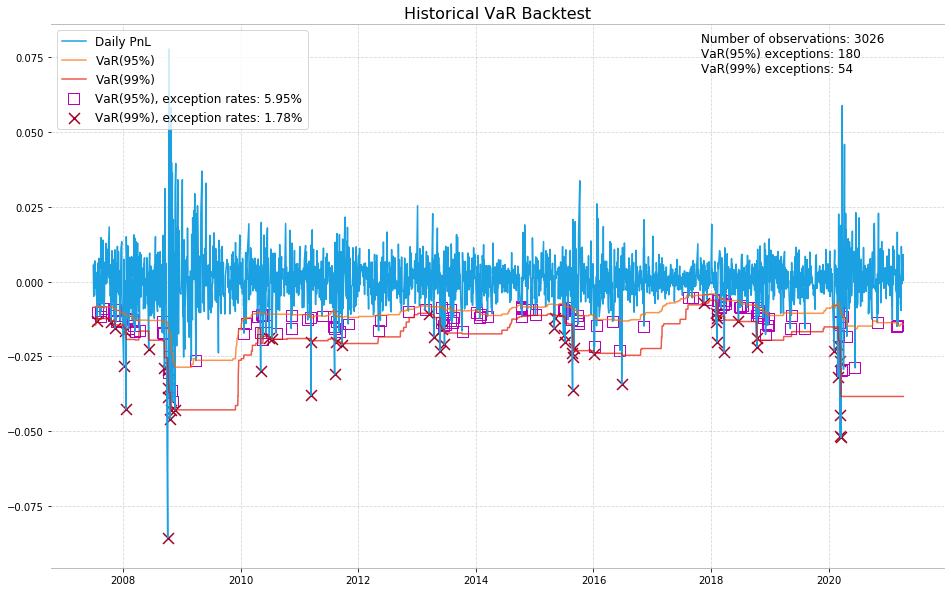

In [14]:
VaR.backtest_plot(hist_var, 'Historical', begin_date='2007-07-01', end_date='2021-06-01')

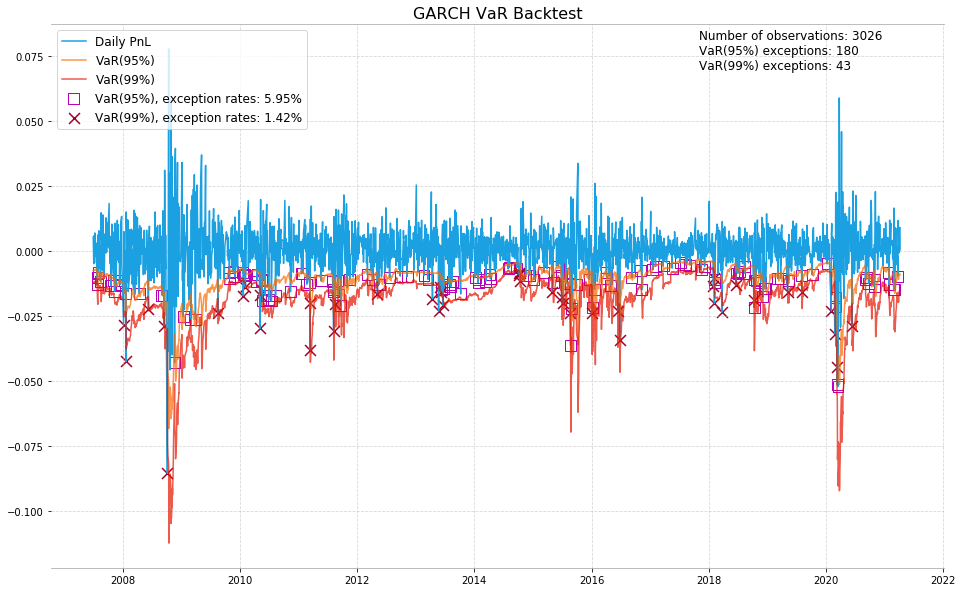

In [15]:
VaR.backtest_plot(garch_var, 'GARCH', begin_date='2007-07-01', end_date='2021-06-01')

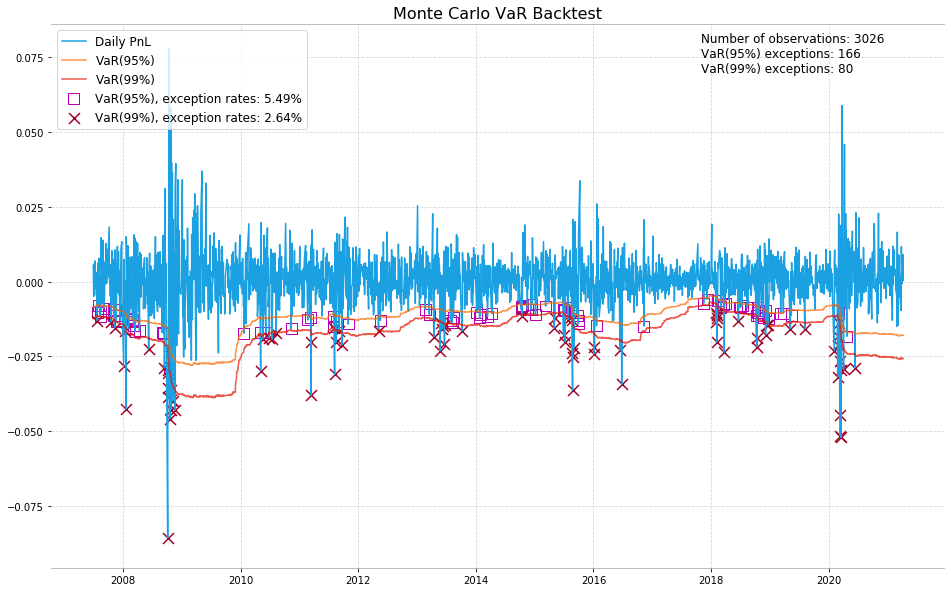

In [16]:
VaR.backtest_plot(mcvar, 'Monte Carlo', begin_date='2007-07-01', end_date='2021-06-01')